<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/capstone/4_5b_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Fellow Citizens:
#### Natural Language Processing Model of Inaugural Addresses

### Table of Contents
1. Preprocessing
    - Import Data and Packages
    - EDA
    - Feature Engineering
    - Clean Data
    - Parse Data
2. Feature Extraction
    - Bag of Words
    - Tf-idf
3. Model Selection
    - Split Test/Training Data
    - Clustering
        - K-Means
        - Mean Shift
        - Spectral Clustering
        - Affinity Propagation
    - Supervised Learning
        - L1/l2 Regression
        - Random Forest
        - Support Vector Machine
    - Assessment
4. Model Tuning
    - Dimensionality Reduction
    - Supervised/Unsupervised Model Comparrison
5. Conclusion

### Import data and packages

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

#from sklearn.metrics import silhouette_score
#from sklearn.model_selection import cross_val_score

In [129]:
filename = 'inaugural'
df_prez = pd.read_csv(filename+".csv", index_col=0)
df_prez.head()

,fileid,target,era,year,president,party,recession,wartime,text_raw,length_raw,text_clean,length_clean,text_parsed,length_parsed,text_nostops,length_nostops
0,1789-Washington.txt,NaN,founding,1789,washington,federalist,0,0,Fellow-Citizens of the Senate and of the House...,8619,fellow citizens of the senate and of the house...,8427,"['fellow', 'citizen', 'of', 'the', 'senate', '...",1394,"['fellow', 'citizen', 'senate', 'house', 'repr...",579
1,1793-Washington.txt,NaN,founding,1793,washington,federalist,0,0,"Fellow citizens, I am again called upon by the...",791,fellow citizens am again called upon by the vo...,763,"['fellow', 'citizen', 'be', 'again', 'call', '...",129,"['fellow', 'citizen', 'call', 'voice', 'countr...",56
2,1797-Adams.txt,NaN,founding,1797,adams,federalist,0,0,"When it was first perceived, in early times, t...",13877,when it was first perceived in early times tha...,13473,"['when', '-PRON-', 'be', 'first', 'perceive', ...",2257,"['perceive', 'early', 'time', 'middle', 'cours...",976
3,1801-Jefferson.txt,NaN,founding,1801,jefferson,democratic-republican,0,0,Friends and Fellow Citizens:\n\nCalled upon to...,10137,friends and fellow citizens called upon to und...,9835,"['friend', 'and', 'fellow', 'citizen', 'call',...",1688,"['friend', 'fellow', 'citizen', 'call', 'under...",723
4,1805-Jefferson.txt,NaN,founding,1805,jefferson,democratic-republican,0,0,"Proceeding, fellow citizens, to that qualifica...",12908,proceeding fellow citizens to that qualificati...,12598,"['proceed', 'fellow', 'citizen', 'to', 'that',...",2128,"['proceed', 'fellow', 'citizen', 'qualificatio...",902


In [130]:
filename = 'inaugural_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.head()

,fileid,text_nostops,government,people,nation,state,great,country,world,power,shall,citizen,time,law,right,peace,good,new,man,american,public,america,duty,constitution,war,free,interest,freedom,united,union,life,year,hope,national,principle,know,let,fellow,work,spirit,...,scope,relative,faction,occasionally,widen,dependence,abolish,columbia,fullness,overcome,probably,uniform,betray,monarchy,complain,potent,strange,mischief,minister,corner,absence,clothe,joint,prudent,accession,inform,temple,annual,asia,levy,economical,rightfully,consume,opening,unmindful,active,sorrow,furnace,justification,channel
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",9,4,3,2,4,5,1,2,3,5,1,0,2,0,3,1,1,2,6,0,5,1,0,2,1,0,4,2,1,1,2,1,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",1,1,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",18,20,20,12,5,10,3,6,4,6,3,2,2,5,7,1,4,3,6,5,3,9,1,2,4,0,3,2,2,5,1,4,3,0,0,3,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",13,2,4,3,4,4,3,5,6,7,0,4,6,5,8,0,9,0,4,0,2,2,1,3,0,4,0,2,1,0,2,0,9,1,7,7,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",3,0,6,12,1,5,2,4,7,10,6,6,4,4,4,1,3,1,14,0,8,6,4,1,8,2,1,3,2,4,0,0,4,2,2,8,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
filename = 'inaugural_tf_idf'
tf_idf = pd.read_csv(filename+".csv", index_col=0)
tf_idf.head()

,fileid,text_nostops,abandon,abandonment,abide,ability,able,abode,abolish,aboriginal,abound,abraham,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstain,abundance,abundant,abundantly,abuse,accept,acceptance,access,accessible,accession,accident,accommodation,accompany,accomplish,accomplishment,accord,accordance,accordingly,account,accountability,accountable,...,wind,window,winter,wipe,wise,wisely,wish,withdraw,wither,withhold,witness,woman,womanhood,wonder,wonderful,word,worker,workingman,worldly,worldwide,worship,worth,worthily,worthy,wound,wrest,writ,write,writer,wrong,yearn,yes,yesterday,yield,yorktown,young,youth,zeal,zealous,zealously
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033835,0.0,0.000000,0.0,0.06622,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061866,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.163159,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",0.030996,0.0,0.0,0.0,0.000000,0.0,0.0,0.040534,0.0,0.0,0.0,0.026315,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029231,0.0,0.0,0.0,0.0,0.0,0.049085,0.0,0.0,0.000000,0.0,0.029231,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022929,0.0,0.067335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035532,0.0,0.0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",0.040103,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034046,0.0,0.0,0.045972,0.0,0.0,0.0,0.0,0.0,0.0,0.075637,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037819,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029665,0.0,0.029039,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035821,0.0,0.059331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045972,0.0,0.0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",0.000000,0.0,0.0,0.0,0.030152,0.0,0.0,0.041811,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.060303,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.030152,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.023152,0.0,0.0,0.0,0.087991,0.0,0.0,0.0,0.000000,0.023651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028559,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109956,0.0,0.0


In [0]:
# set data for modeling
Data_bow = word_counts.drop(['fileid', 'text_nostops'], 1)
Data_tfidf = tf_idf.drop(['fileid', 'text_nostops'], 1)
df = pd.concat([word_counts, tf_idf.drop(['fileid', 'text_nostops'], axis=1)], axis=1)
Data = df.drop(['fileid', 'text_nostops'], axis=1)

## Unsupervised Models

In [0]:
# define dataframes to store results
cluster_desc = pd.DataFrame()
cluster_score = pd.DataFrame()

# define supervised modeling function
def unsupervised_clf(model, data, target, test_size=0.25, stratify=None):
  """
  """
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import silhouette_score, adjusted_rand_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  # silhouette score
  sil_scores = []
  for sample in [X_train, X_test]:
    model.fit(sample)
    labels = model.labels_
    sil_score = silhouette_score(sample, labels, metric='euclidean')
    sil_scores.append(sil_score)
  
  sil_var = np.round(np.var(sil_scores)*100, 4)
  train_sil = np.round(sil_scores[0]*100, 4)
  test_sil = np.round(sil_scores[1]*100, 4)
  print('\nTraining silhouette score:', train_sil)
  print('\nValidation silhouette score:', test_sil)
  print('\nSilhouette score variance:', sil_var)
  
  #rand index
  model.fit(data)
  ARI = np.round(adjusted_rand_score(target, model.labels_), 4)
  print("\nAdjusted rand index variance :", ARI)
  
  return pd.DataFrame([[train_sil, test_sil, sil_var, ARI]],
                      columns=["train_sil_score", "test_sil_score", "sil_var", "ARI"])

### Modeling Recessions

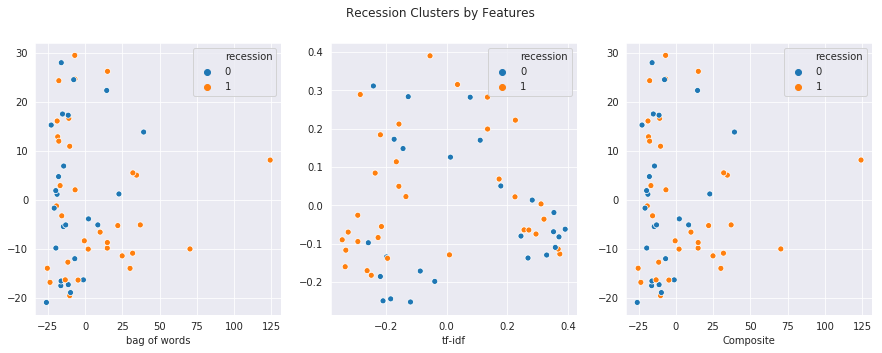

In [134]:
from sklearn.decomposition import PCA
# reduce data to two dimensions
bow_2D = PCA(n_components=2).fit_transform(Data_bow)
tfidf_2D = PCA(n_components=2).fit_transform(Data_tfidf)
data_2D = PCA(n_components=2).fit_transform(Data)

# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=df_prez['recession'], ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=df_prez['recession'], ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=df_prez['recession'], ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Recession Clusters by Features")
plt.show;

#### K-Means

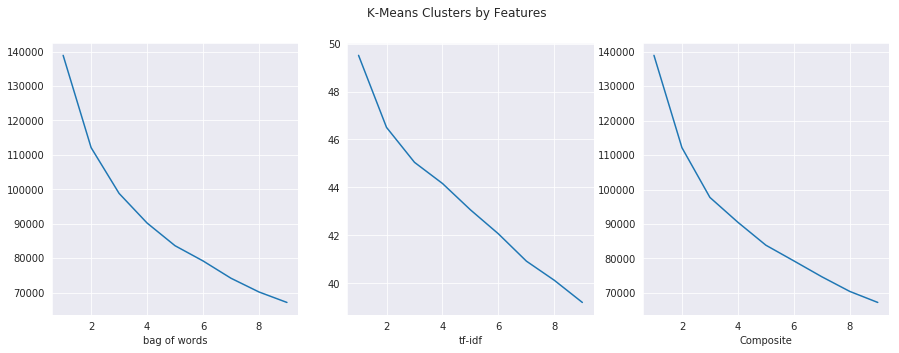

In [135]:
from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
inertia_bow = []
inertia_tfidf = []
inertia_data = []
k_range = list(range(1, 10))

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    inertia_bow.append(kmeans.fit(Data_bow).inertia_)
    inertia_tfidf.append(kmeans.fit(Data_tfidf).inertia_)
    inertia_data.append(kmeans.fit(Data).inertia_)

# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(k_range, inertia_bow, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.lineplot(k_range, inertia_tfidf, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.lineplot(k_range, inertia_data, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("K-Means Clusters by Features")
plt.show;

In [136]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto', random_state=42)
bow_labels = kmeans.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: kmeans


Training silhouette score: 27.642

Validation silhouette score: 27.3636

Silhouette score variance: 0.0002

Adjusted rand index variance : 0.0124


In [137]:
tfidf_labels = kmeans.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: kmeans


Training silhouette score: 4.8383

Validation silhouette score: 3.2437

Silhouette score variance: 0.0064

Adjusted rand index variance : 0.0018


In [138]:
data_labels = kmeans.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: kmeans


Training silhouette score: 27.633

Validation silhouette score: 27.3535

Silhouette score variance: 0.0002

Adjusted rand index variance : 0.0124


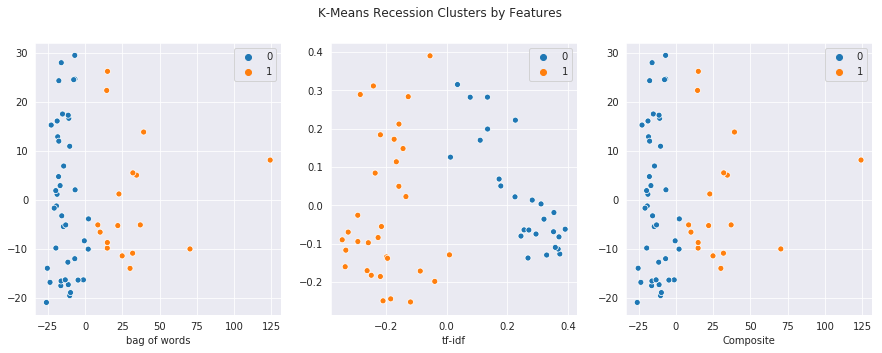

In [139]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("K-Means Recession Clusters by Features")
plt.show;

#### Mean Shift

In [140]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow = estimate_bandwidth(Data_bow, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow)
bow_labels = meanshift.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: mean shift


Training silhouette score: 16.1678

Validation silhouette score: 18.7787

Silhouette score variance: 0.017

Adjusted rand index variance : -0.0301


In [141]:
bandwidth_tfidf = estimate_bandwidth(Data_tfidf, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf)
tfidf_labels = meanshift.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: mean shift



ValueError: ignored

In [142]:
bandwidth_data = estimate_bandwidth(Data, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data)
data_labels = meanshift.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: mean shift


Training silhouette score: 16.1588

Validation silhouette score: 18.7695

Silhouette score variance: 0.017

Adjusted rand index variance : -0.0301


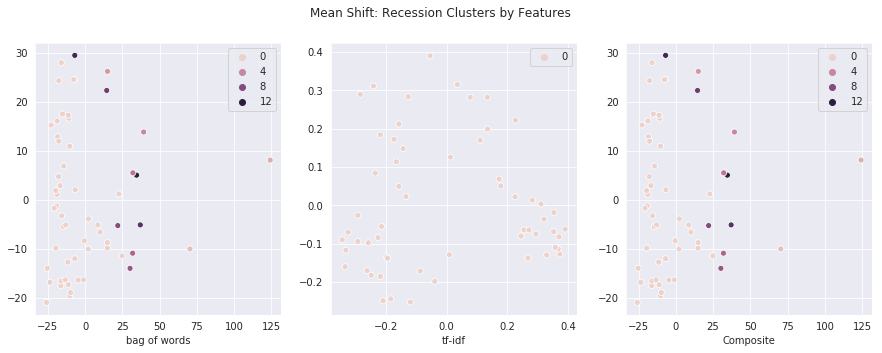

In [143]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Mean Shift: Recession Clusters by Features")
plt.show;

#### Spectral Clustering

In [144]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=2)
bow_labels = spec.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

In [145]:
tfidf_labels = spec.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: spectral


Training silhouette score: 4.8383

Validation silhouette score: 3.0084

Silhouette score variance: 0.0084

Adjusted rand index variance : 0.0018


In [146]:
data_labels = spec.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

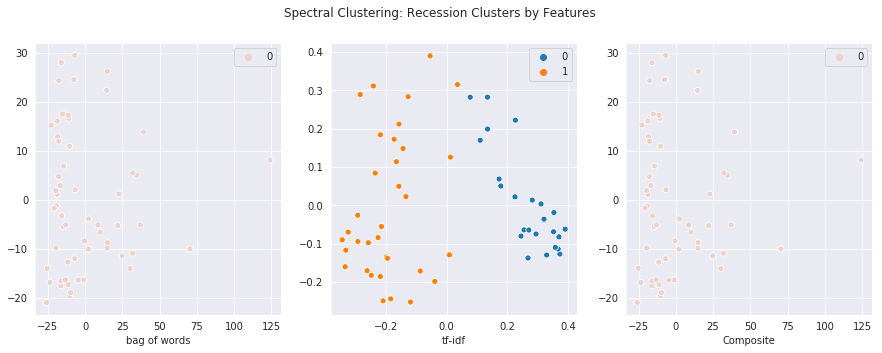

In [147]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Spectral Clustering: Recession Clusters by Features")
plt.show;

#### Affinity Propagation

In [148]:
from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation()
bow_labels = aff.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: affinity


Training silhouette score: 8.1969

Validation silhouette score: 18.7787

Silhouette score variance: 0.2799

Adjusted rand index variance : -0.0276


In [149]:
tfidf_labels = aff.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: affinity


Training silhouette score: 1.0037

Validation silhouette score: 2.8926

Silhouette score variance: 0.0089

Adjusted rand index variance : -0.0175


In [150]:
data_labels = aff.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: affinity


Training silhouette score: 8.1936

Validation silhouette score: 18.7695

Silhouette score variance: 0.2796

Adjusted rand index variance : -0.0276


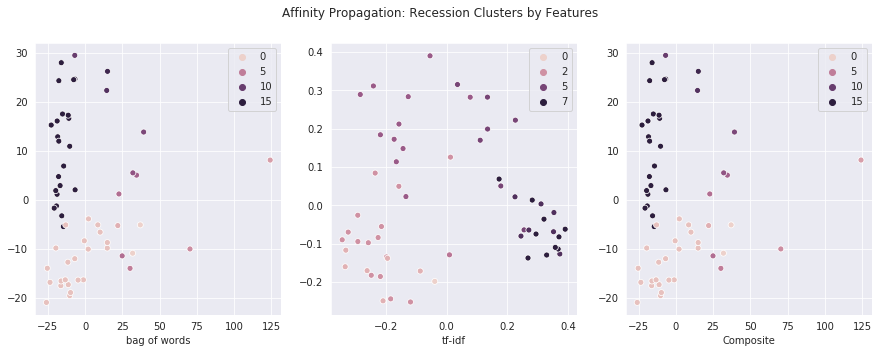

In [151]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Affinity Propagation: Recession Clusters by Features")
plt.show;

#### Agglormerative Clustering

In [152]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
bow_labels = agg.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: agglomerative


Training silhouette score: 8.1969

Validation silhouette score: 18.7787

Silhouette score variance: 0.2799

Adjusted rand index variance : -0.0276


In [153]:
tfidf_labels = agg.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: agglomerative


Training silhouette score: 1.0037

Validation silhouette score: 2.8926

Silhouette score variance: 0.0089

Adjusted rand index variance : -0.0175


In [154]:
data_labels = agg.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: agglomerative


Training silhouette score: 8.1936

Validation silhouette score: 18.7695

Silhouette score variance: 0.2796

Adjusted rand index variance : -0.0276


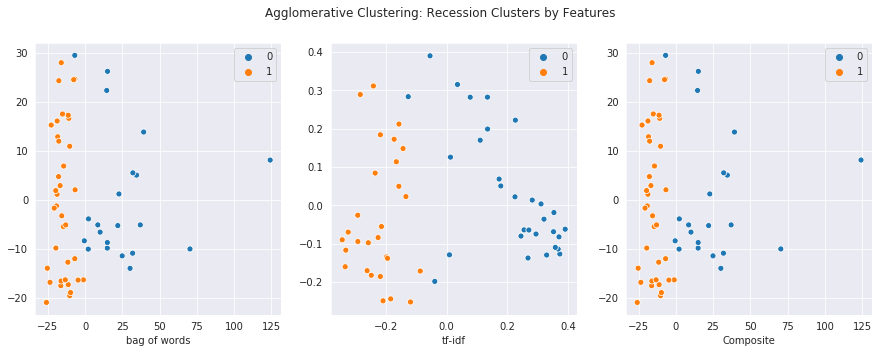

In [155]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Agglomerative Clustering: Recession Clusters by Features")
plt.show;

#### DBSCAN

In [156]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
bow_labels = dbscan.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: DBSCAN



ValueError: ignored

In [157]:
tfidf_labels = dbscan.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: DBSCAN



ValueError: ignored

In [158]:
data_labels = dbscan.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: DBSCAN



ValueError: ignored

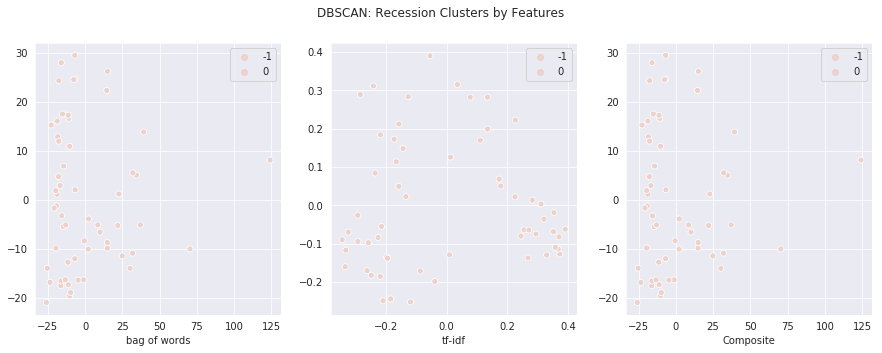

In [159]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("DBSCAN: Recession Clusters by Features")
plt.show;

### Modeling Wartime

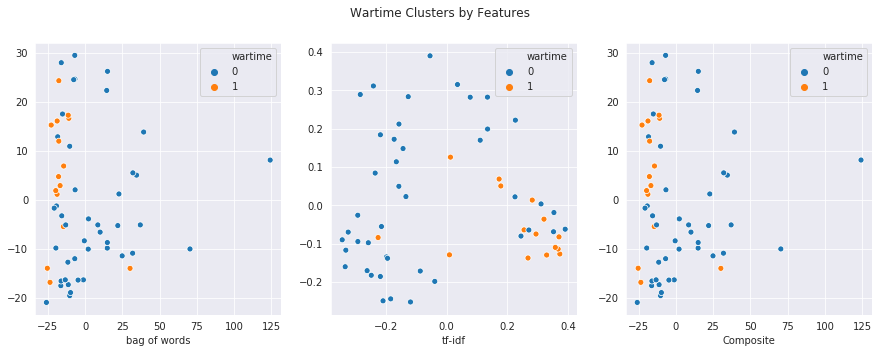

In [160]:
#from sklearn.decomposition import PCA
# reduce data to two dimensions
#bow_2D = PCA(n_components=2).fit_transform(Data_bow)
#tfidf_2D = PCA(n_components=2).fit_transform(Data_tfidf)
#data_2D = PCA(n_components=2).fit_transform(Data)

# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=df_prez['wartime'], ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=df_prez['wartime'], ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=df_prez['wartime'], ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Wartime Clusters by Features")
plt.show;

#### K-Means

In [161]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto', random_state=42)
bow_labels = kmeans.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: kmeans


Training silhouette score: 58.5871

Validation silhouette score: 25.1813

Silhouette score variance: 2.7899

Adjusted rand index variance : -0.0526


In [162]:
tfidf_labels = kmeans.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: kmeans


Training silhouette score: 4.5474

Validation silhouette score: 3.8399

Silhouette score variance: 0.0013

Adjusted rand index variance : 0.2207


In [163]:
data_labels = kmeans.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: kmeans


Training silhouette score: 58.5784

Validation silhouette score: 25.1731

Silhouette score variance: 2.7898

Adjusted rand index variance : -0.0526


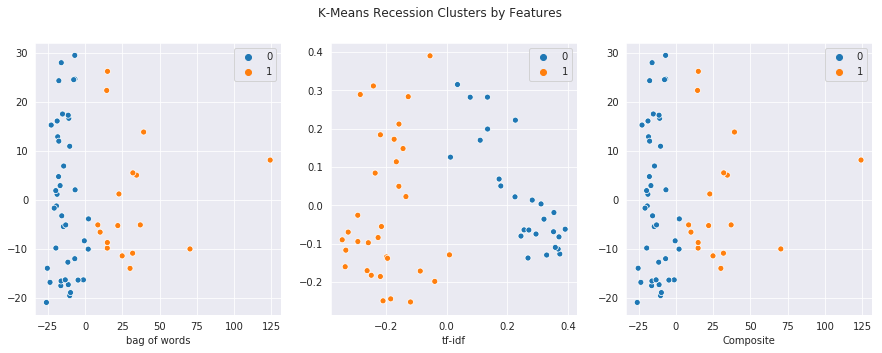

In [164]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("K-Means Recession Clusters by Features")
plt.show;

#### Mean Shift

In [165]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow = estimate_bandwidth(Data_bow, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow)
bow_labels = meanshift.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: mean shift


Training silhouette score: 18.1465

Validation silhouette score: 19.0942

Silhouette score variance: 0.0022

Adjusted rand index variance : -0.1131


In [166]:
bandwidth_tfidf = estimate_bandwidth(Data_tfidf, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf)
tfidf_labels = meanshift.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: mean shift



ValueError: ignored

In [167]:
bandwidth_data = estimate_bandwidth(Data, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data)
data_labels = meanshift.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: mean shift


Training silhouette score: 18.1373

Validation silhouette score: 19.0855

Silhouette score variance: 0.0022

Adjusted rand index variance : -0.1131


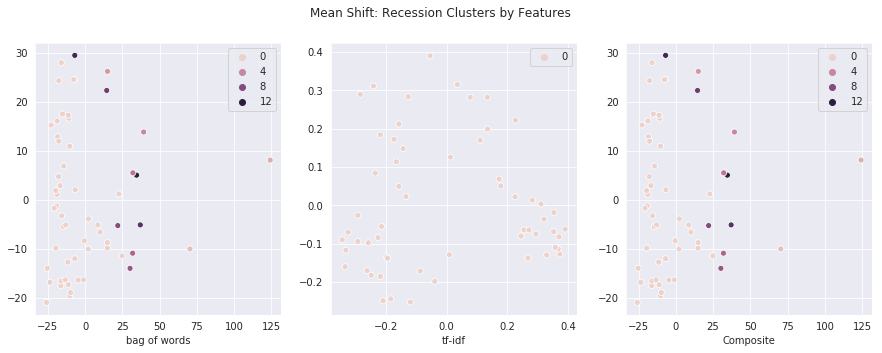

In [168]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Mean Shift: Recession Clusters by Features")
plt.show;

#### Spectral Clustering

In [169]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=2)
bow_labels = spec.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

In [170]:
tfidf_labels = spec.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: spectral


Training silhouette score: 4.6159

Validation silhouette score: 4.1484

Silhouette score variance: 0.0005

Adjusted rand index variance : 0.2174


In [171]:
data_labels = spec.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

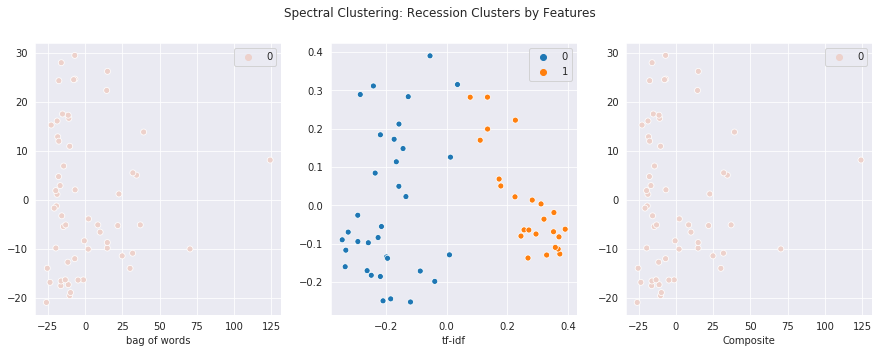

In [172]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Spectral Clustering: Recession Clusters by Features")
plt.show;

#### Affinity Propagation

In [173]:
from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation()
bow_labels = aff.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: affinity


Training silhouette score: 5.6027

Validation silhouette score: 19.0942

Silhouette score variance: 0.4551

Adjusted rand index variance : 0.0465


In [174]:
tfidf_labels = aff.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: affinity


Training silhouette score: 2.3072

Validation silhouette score: 4.4438

Silhouette score variance: 0.0114

Adjusted rand index variance : 0.1078


In [175]:
data_labels = aff.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: affinity


Training silhouette score: 5.5986

Validation silhouette score: 19.0855

Silhouette score variance: 0.4547

Adjusted rand index variance : 0.0465


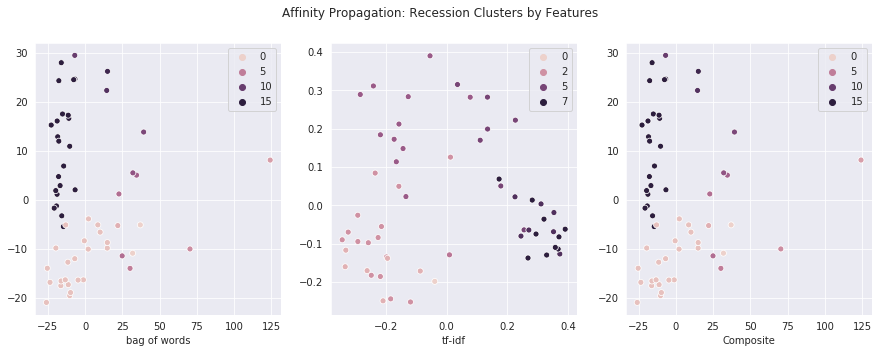

In [176]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Affinity Propagation: Recession Clusters by Features")
plt.show;

#### Agglormerative Clustering

In [177]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
bow_labels = agg.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: agglomerative


Training silhouette score: 5.6027

Validation silhouette score: 19.0942

Silhouette score variance: 0.4551

Adjusted rand index variance : 0.0465


In [178]:
tfidf_labels = agg.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: agglomerative


Training silhouette score: 2.3072

Validation silhouette score: 4.4438

Silhouette score variance: 0.0114

Adjusted rand index variance : 0.1078


In [179]:
data_labels = agg.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: agglomerative


Training silhouette score: 5.5986

Validation silhouette score: 19.0855

Silhouette score variance: 0.4547

Adjusted rand index variance : 0.0465


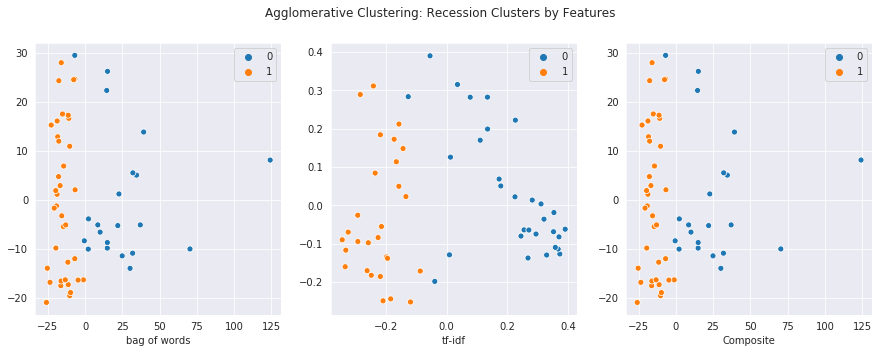

In [180]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("Agglomerative Clustering: Recession Clusters by Features")
plt.show;

#### DBSCAN

In [181]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
bow_labels = dbscan.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: DBSCAN



ValueError: ignored

In [182]:
tfidf_labels = dbscan.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: DBSCAN



ValueError: ignored

In [183]:
data_labels = dbscan.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: DBSCAN



ValueError: ignored

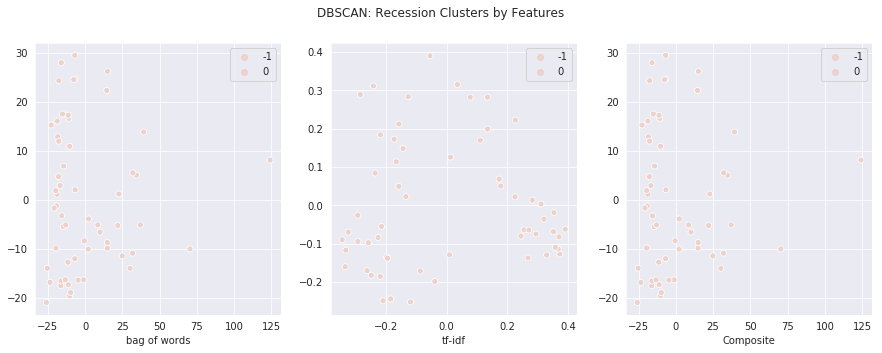

In [184]:
# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(bow_2D[:,0], bow_2D[:,1], hue=bow_labels, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.scatterplot(tfidf_2D[:,0], tfidf_2D[:,1], hue=tfidf_labels, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.scatterplot(data_2D[:,0], data_2D[:,1], hue=data_labels, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("DBSCAN: Recession Clusters by Features")
plt.show;

### Analysis

## Supervised Models

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [0]:
# define dataframes to store results
df_desc = pd.DataFrame()
df_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=None, cv=5):
  """
  """
  from sklearn.model_selection import train_test_split, cross_val_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_score = np.round(np.mean(cv_scores)*100, 4)
  variance = np.round(np.var(cv_scores)*100, 4)
  print('\nCross validation: {} +/- {}%'.format(cv_score, variance))
  
  return pd.DataFrame([[train_score, test_score, cv_score, variance]],
                      columns=["train_score", "test_score", "cv_score", "variance"])

### Modeling Recessions

#### Naive Bayes

In [0]:
#from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.8

Cross validation: 72.2727 +/- 0.1942%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.8

Cross validation: 72.2727 +/- 0.1942%


#### L1 Regularization

In [0]:
#from sklearn.linear_model import LogisticRegression
# set penalty to 'l1'
# set penalty to 'saga'
lasso = LogisticRegression(penalty='l1',
                           solver='saga',
                           multi_class='auto',
                           random_state=42,
                           #max_iter=1500
                          )
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: lasso regression


Training score: 1.0

Validation score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: lasso regression


Training score: 0.7441860465116279

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: lasso regression



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Training score: 1.0

Validation score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### L2 Regularization

In [0]:
#from sklearn.linear_model import LogisticRegression
# set penalty to 'l2'
# set solver to 'lbfgs'
ridge = LogisticRegression(penalty='l2',
                           solver='lbfgs',
                           #multi_class='multinomial',
                           random_state=42)
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: ridge regression


Training score: 1.0

Validation score: 0.8

Cross validation: 73.6364 +/- 2.432%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: ridge regression


Training score: 0.7441860465116279

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: ridge regression


Training score: 1.0

Validation score: 0.8

Cross validation: 73.6364 +/- 2.432%


#### Random Forest

In [0]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: random forest


Training score: 1.0

Validation score: 0.8

Cross validation: 74.0909 +/- 0.0124%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


#### Support Vector Machines

In [0]:
#from sklearn.svm import SVC
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: svm


Training score: 0.8604651162790697

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: svm


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: svm


Training score: 0.8372093023255814

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


#### SGD Classifier

In [128]:
#from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
df_desc = df_desc.append(pd.DataFrame([["recession", "bag of words", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data_bow,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: recession
Features: bag of words
Model: sgd


Training score: 1.0

Validation score: 0.5333333333333333

Cross validation: 51.3636 +/- 0.8113%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "tf-idf", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data_tfidf,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: sgd


Training score: 1.0

Validation score: 0.8666666666666667

Cross validation: 73.6364 +/- 3.7544%


In [0]:
df_desc = df_desc.append(pd.DataFrame([["recession", "composite", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data,
                                          target=df_prez['recession'],
                                          stratify=df_prez['recession']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: sgd


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 73.7879 +/- 4.0326%


### Modeling Wartime

#### Naive Bayes

In [77]:
#from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.8

Cross validation: 72.2727 +/- 0.1942%


In [78]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [79]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "naive bayes"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=bayes,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: Naive Bayes (Gaussian)


Training score: 1.0

Validation score: 0.8

Cross validation: 72.2727 +/- 0.1942%


#### L1 Regularization

In [80]:
#from sklearn.linear_model import LogisticRegression
# set penalty to 'l1'
# set penalty to 'saga'
lasso = LogisticRegression(penalty='l1',
                           solver='saga',
                           multi_class='auto',
                           random_state=42,
                           #max_iter=1500
                          )
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: lasso regression


Training score: 1.0

Validation score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [81]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: lasso regression


Training score: 0.7441860465116279

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [82]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "lasso regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=lasso,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: lasso regression



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Training score: 1.0

Validation score: 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Cross validation: 75.303 +/- 3.9109%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### L2 Regularization

In [83]:
#from sklearn.linear_model import LogisticRegression
# set penalty to 'l2'
# set solver to 'lbfgs'
ridge = LogisticRegression(penalty='l2',
                           solver='lbfgs',
                           #multi_class='multinomial',
                           random_state=42)
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: ridge regression


Training score: 1.0

Validation score: 0.8

Cross validation: 73.6364 +/- 2.432%


In [84]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: ridge regression


Training score: 0.7441860465116279

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [85]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "ridge regression"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=ridge,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: ridge regression


Training score: 1.0

Validation score: 0.8

Cross validation: 73.6364 +/- 2.432%


#### Random Forest

In [86]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [87]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: random forest


Training score: 1.0

Validation score: 0.8

Cross validation: 74.0909 +/- 0.0124%


In [88]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "random forest"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=rfc,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


#### Support Vector Machines

In [90]:
#from sklearn.svm import SVC
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: svm


Training score: 0.8604651162790697

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


In [91]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: svm


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [92]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "svm"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=svc,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: svm


Training score: 0.8372093023255814

Validation score: 0.7333333333333333

Cross validation: 72.2727 +/- 0.1942%


#### SGD Classifier

In [93]:
#from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
df_desc = df_desc.append(pd.DataFrame([["wartime", "bag of words", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data_bow,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: bag of words
Model: sgd


Training score: 1.0

Validation score: 1.0

Cross validation: 69.8485 +/- 5.9376%


In [94]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "tf-idf", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data_tfidf,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: tf-idf
Model: sgd


Training score: 1.0

Validation score: 0.8666666666666667

Cross validation: 73.6364 +/- 3.7544%


In [95]:
df_desc = df_desc.append(pd.DataFrame([["wartime", "composite", "sgd"]],
                                      columns=["target", "features", "model"]),
                        ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
df_score = df_score.append(supervised_clf(model=sgd,
                                          data=Data,
                                          target=df_prez['wartime'],
                                          stratify=df_prez['wartime']),
                          ignore_index=True)

Target: wartime
Features: composite
Model: sgd


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 73.7879 +/- 4.0326%


### Analysis

In [127]:
df_score[["cv_score", "variance"]].loc[df_score.describe()

,cv_score,variance
count,18.000000,18.000000
mean,73.190228,1.545522
std,1.332557,1.959909
min,69.848500,0.012400
25%,72.272700,0.194200
50%,73.636400,0.194200
75%,74.090900,3.423800
max,75.303000,5.937600


In [123]:
df_test = pd.concat([df_desc.reset_index(), df_score], axis=1)
df_test.sort_values(by=["cv_score"], ascending=False).head(10)

,index,target,features,model,train_score,test_score,cv_score,variance
3,0,wartime,bag of words,lasso regression,1.000000,0.866667,75.3030,3.9109
5,0,wartime,composite,lasso regression,1.000000,0.866667,75.3030,3.9109
4,0,wartime,tf-idf,lasso regression,0.744186,0.733333,74.0909,0.0124
7,0,wartime,tf-idf,ridge regression,0.744186,0.733333,74.0909,0.0124
10,0,wartime,tf-idf,random forest,1.000000,0.800000,74.0909,0.0124
13,0,wartime,tf-idf,svm,1.000000,0.733333,74.0909,0.0124
17,0,wartime,composite,sgd,1.000000,0.733333,73.7879,4.0326
16,0,wartime,tf-idf,sgd,1.000000,0.866667,73.6364,3.7544
6,0,wartime,bag of words,ridge regression,1.000000,0.800000,73.6364,2.4320
8,0,wartime,composite,ridge regression,1.000000,0.800000,73.6364,2.4320


## Supervised/Unsupervised Model Assessment
None of the unsupervised models demonstrated accurate clustering ability, with Spectral Clustering failing outright.
All of the clustering models seemed to focus around target group 3, the inaugural addresses of modern presidents. The models seem to at least be able to differentiate modern presidential speeches from those of World Ward 2, Civil War, and early presidents. The all around strongest model was K-Means trained on the Bag of Words features. The model had a consistent and (relatively) high silhouette score compared to the other unsupervised models.

The supervised models for the most part exhibited overfitting with lackluster classification performance in the 60-70% accuracy range. The most accurate model was the Ridge Regression trained on the Tf-Idf features. The model demonstrated very high classification accuracy and cross validation score, though it also did have a high variance compared to the other supervised models.

With some tuning we should expect model performance to improve accross the supervised and unsupervised models.